In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import (models, transforms)
import os
import utils
from pathlib import Path
import trainer
from torchinfo import summary
import time
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/p3rzival/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# Preparation of the model

We will be using the original ViT in its smallest form (The ViT_B_16) to test the quantization results together with the Imaginette dataset

In [ ]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)
pretrained_vit_transforms = pretrained_vit_weights.transforms()

In [ ]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=10).to(device)

In [ ]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

We first will do fine-tunning to adecuate the model to the CIFAR10 dataset. Since we just want to test the efficency the quantization achieves and its tradeoff with accuracy, we will train the model for a small number of epochs, since what we want to see is how the accuracy is maintained ¡, and for that we do not need to fit the model perfectly to our data

In [ ]:
train_dl, test_dl, val_dl, class_names = utils.create_loaders("data", transform=pretrained_vit_transforms, batch_size=128)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pretrained_vit.parameters(), lr=0.03, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=10000)

In [ ]:
pretrained_vit_results = trainer.train(model=pretrained_vit, train_dataloader=train_dl, 
                                       test_dataloader=test_dl, optimizer=optimizer, scheduler=scheduler,
                                       loss_fn=loss_fn, epochs=5, device=device)

In [ ]:
utils.plot_loss_curves(pretrained_vit_results)

After looking at the loss and accuracy curves it seems that our model could benefit from training some additional epochs, but since fitting the model to this particular data is not our goal right now, we will leave it like that

Let's save the model

In [ ]:
target_dir_path = Path("model")
target_dir_path.mkdir(parents=True,
                    exist_ok=True)

# Create model save path
model_save_path = target_dir_path / "ViT-Default.pht"

# Save the model state_dict()
print(f"[INFO] Saving model to: {model_save_path}")
torch.save(obj=pretrained_vit.state_dict(),
        f=model_save_path)

Now let's see how does it perform on the validation data, how much times does it take to give us the answer and how much does it weight

In [ ]:
trainer.evaluate(pretrained_vit, val_dl, loss_fn, device)

/home/p3rzival/TFG-Efficient-Vision-Transformer-Inference-on-Edge-Devices/utils.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit.load_state_dict(torch.load(model_pa

Files already downloaded and verified
Doing warm-up runs...
Ended warm-up, beginning true runs...


100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


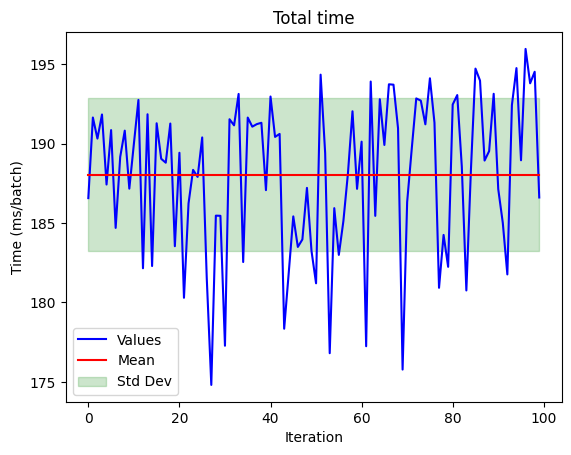

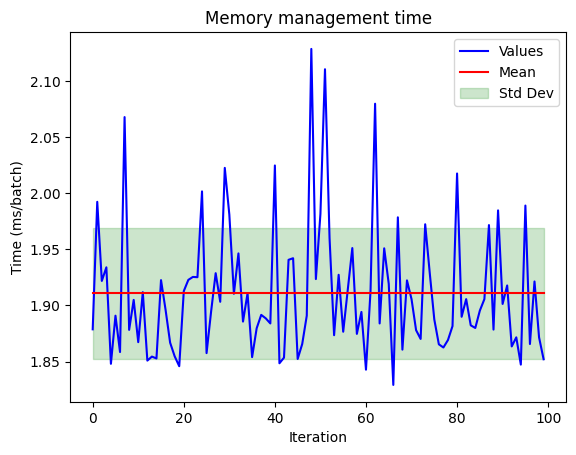

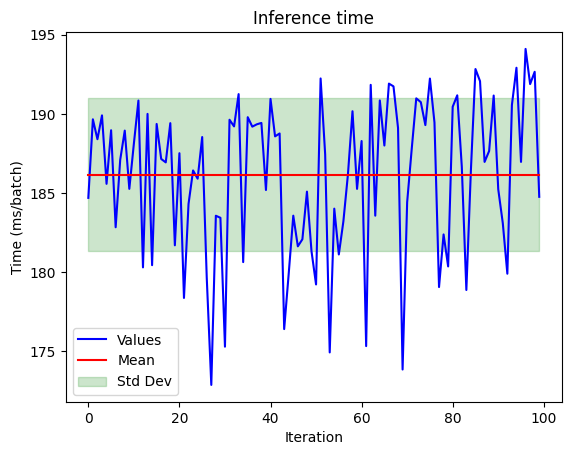

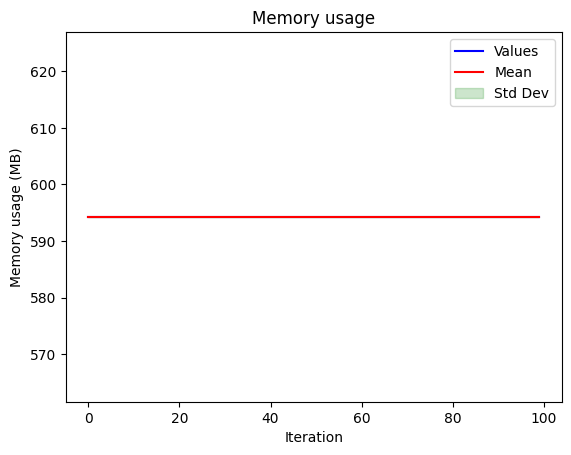

Mean total time over 100 executions: 188.05874824523926 ms/batch 
Mean memory time over 100 executions: 1.9107723236083984 ms/batch 
Mean inference time over 100 executions: 186.14797592163086 ms/batch 
Mean memory over 100 executions: 594.26513671875 MB


In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = utils.load_default_model()
pretrained_vit_transforms = pretrained_vit_weights.transforms()
_, _, val_dl, _ = utils.create_loaders("data", transform=pretrained_vit_transforms, batch_size=32)
metrics = trainer.getMetrics(pretrained_vit, val_dl, device, num_times=100, save_plots=True, model_title="ViT-Default")